## Linear Regression 

## Part 1 - Getting Started

In this project, we are designing a controller to manage the ailerons of an F16 Aircraft! 
![Ailerons](https://raw.githubusercontent.com/aps1070-2019/datasets/master/img/airplane.gif) [Ref](https://www.grc.nasa.gov/www/k-12/BGA/Mike/airplane_parts_act.htm) 


The features describe the airplane's status, and the target is to predict the `Goal` column, which is a command that our controller should issue.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

1. Split the dataset into training/validation sets (80% training, 20% validation). 
2. Standardize the data using StandardScaler from sklearn.

In [62]:
# split traning and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:,-1], test_size=0.2, random_state=41)

# standardize 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## Part 2 - Direct Solution 

Implement the direct solution for linear regression on the dataset above (without regularizer).


In [63]:
from sklearn.metrics import mean_squared_error
# calculate rmse
def rmse(yPred, y):
    return np.sqrt(mean_squared_error(yPred, y))

# add bias to data using constant ones at w0
X_train_std = np.vstack((np.ones(np.shape(X_train_std)[0]), X_train_std.T)).T
X_test_std =  np.vstack((np.ones(np.shape(X_test_std)[0]), X_test_std.T)).T

In [64]:
# direct solution
W = np.dot(np.linalg.inv(np.dot(X_train_std.T, X_train_std)), np.dot(X_train_std.T, y_train))

yPred_train = np.dot(X_train_std, W)
rmse_train = rmse(yPred_train, y_train)
print('training rmse',rmse_train)

yPred_test = np.dot(X_test_std, W)
rmse_test = rmse(yPred_test, y_test)
print('validation rmse',rmse_test)

training rmse 0.0001820497133152199
validation rmse 0.00018282578955074112


Small RMSE values proves the validility of the direct solution implementation

## Part 3 - Gradient Descent (GD) 

1. Implement gradient descent (full-batch) for linear regression using a fixed learning rate of $\alpha= 1e-2$.

2. Run the gradient descent for a fixed number of epochs (based on convergence) and verify that the results are closely approximate the direct solution.

In [65]:
def gradientDescent(x, y, alpha=1e-2, epochs=500):
    n, m = x.shape
    w = np.zeros(x.shape[1])
    costs = []
    errors = []
    weights = []

    for i in range(epochs):
        # computer gradient descent 
        hypothesis = np.dot(x, w)
        loss = hypothesis - y
        cost = np.sum(loss ** 2) / (2.0 * n)
        costs.append(cost)
        gradient = np.dot(x.T, loss) / n    
        w -= alpha * gradient 
        weights.append(w.copy())
        # compute rmse error 
        error = rmse(np.dot(x, w), y)
        errors.append(error)
    return w, costs, errors, weights

training rmse: 0.00017451956543024748
validation rmse: 0.00017253497932767016


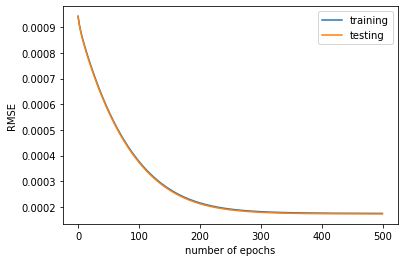

In [66]:
import matplotlib.pyplot as plt

plt.xlabel('number of epochs')
plt.ylabel('RMSE')

# training data 
w, costs, training_errors, weights = gradientDescent(X_train_std, y_train)
plt.plot(training_errors)
print('training rmse:', training_errors[-1])

# testing data 
testing_errors = []
for w in weights:
  testing_errors.append(rmse(np.dot(X_test_std, w), y_test))
plt.plot(testing_errors)
print('validation rmse:', testing_errors[-1])

plt.legend(['training', 'testing'])

The results are very close to the direct method, validating its performance.

* direct solution:  0.0001820497133152199
* gradient descent: 0.00017451956543024748

## Part 4 - Mini-batch and Stochastic Gradient Descent 

When B=1, we call that stochastic gradient descent.  When B=#train data points, it is full-batch (ie all data points are used, every cycle). Anywhere in between is mini-batch (we use some of the data).  

1. Implement Mini-batch Gradient Descent.

2. Sweep different values for the mini-batch size (including 1 -- Stochastic GD) with a fixed learning rate and report your findings on a plot (training error and validation error vs. iterations).

In [67]:
def mini_batch_GD(X, y, alpha=1e-2, epochs=100, batch_size = 32):
    n, m = X.shape
    w = np.zeros(X.shape[1])
    costs = np.zeros(epochs)
    errors_perIteration = []
    errors_perEpoch = []
    weights_perIteration = []
    weights_perEpoch = []

    for ep in range(epochs):
      cost =0.0
      np.random.seed(41)
      # randomly select minibatch for each epoch 
      indices = np.random.permutation(m)
      X_shuffled = X[indices]
      y_shuffled = y.iloc[indices]
      
      # create mini batches
      for i in range(0,m,batch_size):
        if i+batch_size >= m:
          X_i = X_shuffled[i:]
          y_i = y_shuffled[i:]
        else:
          X_i = X_shuffled[i:i+batch_size]
          y_i = y_shuffled[i:i+batch_size]

        # compute gradient 
        n, m = X_i.shape
        hypothesis = np.dot(X_i, w)
        loss = hypothesis - y_i
        cost += np.sum(loss ** 2) / (2. * n)
        gradient = np.dot(X_i.T, loss) / n 
        w -= alpha * gradient 
        
        # calculate errors 
        errors_perIteration.append(rmse(np.dot(X, w), y))
        weights_perIteration.append(w.copy())

      errors_perEpoch.append(rmse(np.dot(X, w), y))
      weights_perEpoch.append(w.copy())
      costs[ep]  = cost / n

    return w, costs, errors_perEpoch, errors_perIteration, weights_perEpoch, weights_perIteration

Text(0.5, 1.0, 'testing')

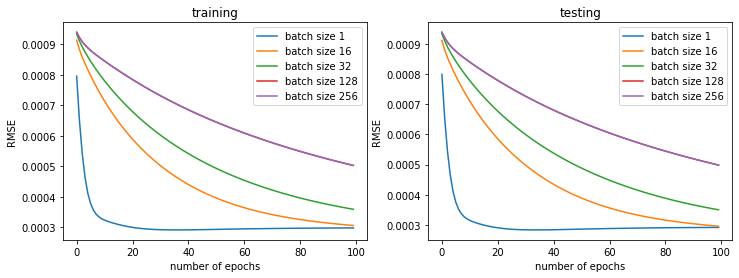

In [68]:
# plot RMSE after each epoch

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,  subplot_kw=dict(xlabel="number of epochs", ylabel='RMSE'), figsize=(12,4))

batch = [1,16, 32, 128, 256]
for b in batch: 
  w, costs, errors_epoch, errors_iter, weights_epoch, weights_iter = mini_batch_GD(X_train_std, y_train, alpha=0.01, epochs=100, batch_size=b)
  ax1.plot(errors_epoch, label='batch size {}'.format(b))

  testing_error = []
  for w in weights_epoch:
    testing_error.append(rmse(np.dot(X_test_std, w), y_test))
  ax2.plot(testing_error, label='batch size {}'.format(b))

[ax.legend() for ax in [ax1, ax2]]
ax1.set_title('training')
ax2.set_title('testing')

Text(0.5, 1.0, 'testing')

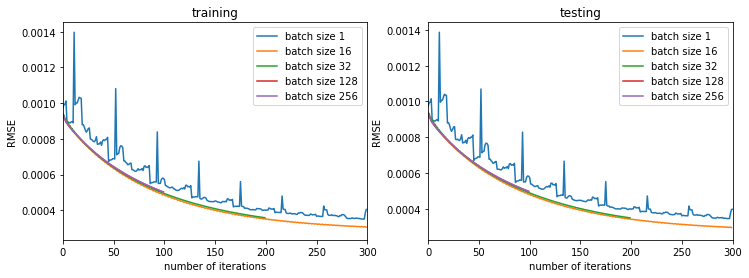

In [69]:
# plot RMSE of each gradient update iterations

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,  subplot_kw=dict(xlabel="number of iterations", ylabel='RMSE', xlim=(0,300)), figsize=(12,4))

batch = [1,16, 32, 128, 256]
for b in batch: 
  w, costs, errors_epoch, errors_iter, weights_epoch, weights_iter = mini_batch_GD(X_train_std, y_train, alpha=0.01, epochs=100, batch_size=b)
  ax1.plot(errors_iter, label='batch size {}'.format(b))

  testing_error = []
  for w in weights_iter:
    testing_error.append(rmse(np.dot(X_test_std, w), y_test))
  ax2.plot(testing_error, label='batch size {}'.format(b))

[ax.legend() for ax in [ax1, ax2]]
ax1.set_title('training')
ax2.set_title('testing')

* By ploting RMSE of each epoch, we can see that having a small batch size makes the model converges faster. However, it's only because Stochastic GD updates its gradient so many times in each epoch. If we plot the RMSE after each iteration of gradient updates, we can see that all batch size converges at similar rate. 
* The number of iterations required in Stochastic GD is so high that it takes a long time to compute all iterations. It also shows a noisy curve that fluctuates up and down because its small batch size of 1 is sensitive to noise and variance.

* On the other hand, a large batch size does not require many iterations in each epochs and it's more stable in convergence, but its large matrix dimension makes it  computational heavy. It also requires more epochs to converge. 

* Therefore, an optimal batch size should be a relatively small batch size but not too small. In this model, 16 is found to be a suitable number. It can converge at faster speed and results a better accuracy.




## Part 5 - Learning Rate 
Select the best batch size based on fastest convergence (number of times weights are updated) and sweep the learning rate while applying Mini-batch GD. 

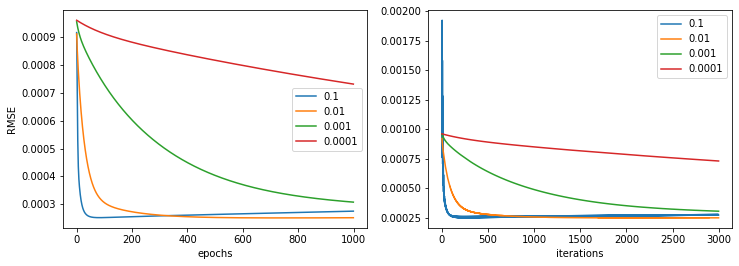

In [70]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,  figsize=(12,4))

learningRates = [0.1, 0.01, 0.001, 0.0001]
for lr in learningRates: 
  w, costs, errors_epoch, errors_iter, weights_epoch, weights_iter = mini_batch_GD(X_train_std, y_train, alpha=lr, epochs=1000, batch_size=16)
  ax1.plot(errors_epoch)
  ax2.plot(errors_iter)

ax1.set_xlabel('epochs')
ax1.set_ylabel('RMSE')
ax2.set_xlabel('iterations')
[ax.legend(learningRates) for ax in [ax1, ax2]]

* When the learning rate is too small, gradient descent is slow that it requires too much time to converge (seen in alpha=0.0001)
* When the learning rate is too large, gradeint descent can overshoot the minima, it fails to converge and even diverges (seen in alpha=0.1)
* The optimal learning rate for this model is 0.01

## Part 6 - Regularizers 



1.   Formula 
  *   Derive the Direct solution formula when a L1 regularizer ($\lambda_1$) is employed.
  *   Derive the Direct solution formula when a L2 regularizer ($\lambda_2$) is employed.
  *   Derive the Gradient Descent weight update formula when the L1 regularizer is employed.
  *   Derive the Gradient Descent weight update formula when the L2 regularizer is employed.



2.   Evaluation:

  *  Apply L1 and L2 regularizers (separately) to the direct solution and plot train and validation error as a function of the $\lambda$. Find the best regularizer ($\lambda$) values to use in the next steps.

    *   Plot mini-batch GD train error and validation error when $\lambda_1$ regularizer is employed. (X-axis: iterations)

    *   Plot mini-batch GD train error and validation error when $\lambda_2$ regularizer is employed. (X-axis: iterations)



* Whether L1 or L2 regularizers are helping the GD convergence. Is it always safe to use a L1 regularizer? How about L2?



#### L1 regularizer direct solution


$J(w) = \frac{1}{2N}[\sum_{i=1}^N(h_w (x^{(i)}) - t^{(i)})^2 + \lambda\sum_{j=1}^n |w_j|]$ 

$J(w) = \frac{1}{2N}||Xw-t||^2+\lambda |w| $

$J(w) = \frac{1}{2N}[(Xw)^T(Xw)-2t^TXw-t^Tt+\lambda |w|]$

$ \frac{\partial J}{\partial w} = \frac{\partial}{\partial w} [w^T X^T Xw] - \frac{\partial}{\partial w} [2t^Txw] - \frac{\partial}{\partial w} [t^Tt] + \frac{\partial}{\partial w} [\lambda |w|]$

$\frac{\partial}{\partial w} [w^T X^T xw] = x^TXw+(X^TX)^Tw =X^T Xw + X^TXw = 2X^TXw$ 

$\frac{\partial}{\partial w} [-2t^TXw] = (-2t^TX)^T = -2x^Tt$

$\frac{\partial}{\partial w} [t^Tt] = 0 $

$\frac{\partial }{\partial w} [\lambda |w|] = \begin{cases}
-\lambda,\ for\ w_i<0 \\
[-\lambda,\lambda],\ for\ w_i=0 \\
\lambda,\ for\  w_i >0 \\
\end{cases} $

$\frac{\partial J}{\partial w} = 2X^TXw - 2X^Tt + \frac{\partial }{\partial w} [\lambda |w|]   = 0 $

Beause of |w|, w can't be isoloated, therefore there does not exist a closed-form direct solution for L1.

#### L2 regularizer direct solution


$J(w) = \frac{1}{2N}[\sum_{i=1}^N(h_w (x^{(i)}) - t^{(i)})^2 + \lambda\sum_{j=1}^nw^2_j]$ 

$J(w) = \frac{1}{2N}||Xw-t||^2+\lambda w^2 $

$J(w) = \frac{1}{2N}[(Xw)^T(Xw)-2t^TXw-t^Tt+\lambda w^2]$

$ \frac{\partial J}{\partial w} = \frac{\partial}{\partial w} [w^T X^T Xw] - \frac{\partial}{\partial w} [2t^Txw] - \frac{\partial}{\partial w} [t^Tt] + \frac{\partial}{\partial w} [\lambda w^2]$

$\frac{\partial}{\partial w} [w^T X^T xw] = x^TXw+(X^TX)^Tw =X^T Xw + X^TXw = 2X^TXw$ 

$\frac{\partial}{\partial w} [-2t^TXw] = (-2t^TX)^T = -2x^Tt$

$\frac{\partial}{\partial w} [t^Tt] = 0 $

$\frac{\partial }{\partial w} [\lambda w^2] = 2\lambda w $

$\frac{\partial J}{\partial w} = 2X^TXw - 2X^Tt+2\lambda w = 0 $

$ X^TXw + \lambda w = X^Tt $

$w[X^TX+\lambda I] = X^Tt$

$ w = (X^TX+\lambda I )^{-1}X^Tt $

####  L1 regularized Gradient Descent

$J(w) = \frac{1}{2N}[\sum_{i=1}^N((h_w (x^{(i)}) - t^{(i)})^2  + \lambda\sum_{j=1}^n|w_j|]$ 


$\frac{{\partial J}}{\partial w}=\frac{1}{2N}[\sum_{i=0}^N2~x^{(i)}~((wx^{(i)}+b)-t^{(i)}) + \lambda \sum_{j=1}^n sign(w_j) ]$

####  L2 regularized Gradient Descent

$J(w) = \frac{1}{2N}[\sum_{i=1}^N((h_w (x^{(i)}) - t^{(i)})^2  + \lambda\sum_{j=1}^nw_j^2]$ 


$\frac{{\partial J}}{\partial w}=\frac{1}{2N}[\sum_{i=0}^N2~x^{(i)}~((wx^{(i)}+b)-t^{(i)}) + 2\lambda \sum_{j=1}^nw_j]$

$\frac{{\partial J}}{\partial w}=\frac{1}{N}[\sum_{i=0}^N ~x^{(i)}~((wx^{(i)}+b)-t^{(i)}) + \lambda \sum_{j=1}^nw_j]$




#### Lasso Direct Solution Implementation

No closed form solution can be derived for Lasso.

#### Ridge Direct Solution Implementation

$ w = (X^TX+\lambda I )^{-1}X^Tt $

best lambda = 1e-05, training rmse = 0.00017382277959123902, testing rmse = 0.0001717341486332211


Text(0, 0.5, 'RMSE')

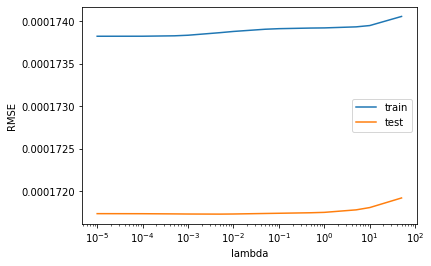

In [71]:
lambda_ = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]
errors_train = []
errors_test = []
for l in lambda_:
  w = np.dot(np.linalg.inv((np.dot(X_train_std.T, X_train_std) + l*np.identity(X_train_std.shape[1]))), np.dot(X_train_std.T, y_train))
  errors_train.append(rmse(np.dot(X_train_std, w), y_train))
  errors_test.append(rmse(np.dot(X_test_std, w), y_test))

plt.plot(lambda_, errors_train)
plt.plot(lambda_, errors_test)
plt.xscale('log')
minIdx = np.argmin(errors_train)
print('best lambda = {}, training rmse = {}, testing rmse = {}'.format(lambda_[minIdx], errors_train[minIdx], errors_test[minIdx]))
plt.xlabel('lambda')
plt.legend(['train', 'test'])
plt.ylabel('RMSE')

#### Lasso Mini Batch Gradient Descent

In [72]:
def mini_batch_lasso(X, y, alpha=1e-2,epochs=100,batch_size = 16, l=1e-5):
    n, m = X.shape
    w = np.zeros(X.shape[1])
    errors = []
    weights = []

    # create mini batches
    for i in range(epochs):
          cost =0.0
          np.random.seed(41)
          indices = np.random.permutation(m)
          X_shuffled = X[indices]
          y_shuffled = y.iloc[indices]
          
          # computer gradient descent 
          for i in range(0,m,batch_size):
            if i+batch_size >= m:
              X_i = X_shuffled[i:]
              y_i = y_shuffled[i:]
            else:
              X_i = X_shuffled[i:i+batch_size]
              y_i = y_shuffled[i:i+batch_size]

            n, m = X_i.shape
            hypothesis = np.dot(X_i, w)
            loss = hypothesis - y_i
            # adds L1 regularizer
            # weight update based on the sign of W 
            gradient = (2*np.dot(X_i.T, loss) + l*np.sign(w)) / (2.0*n) 
            w -= alpha * gradient 

            errors.append(rmse(np.dot(X, w), y))
            weights.append(w.copy())
          
    return w, errors, weights

training RMSE = 0.00021076399347103776
training RMSE with no regularizaiton = 0.0002510537350651724
testing RMSE = 0.00020621976795179086
testing RMSE with no regularizaiton = 0.00024464645914461925


Text(0.5, 1.0, 'testing data')

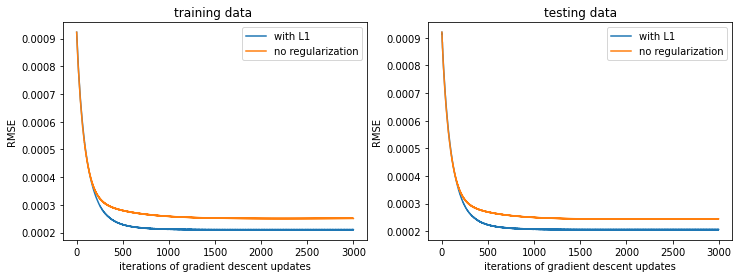

In [73]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,  subplot_kw=dict(xlabel="iterations of gradient descent updates", ylabel='RMSE'), figsize=(12,4))

# train with L1
w, errors, weights = mini_batch_lasso(X_train_std,y_train, alpha=1e-2,epochs=1000,batch_size = 16, l=0.001)
ax1.plot(errors, label='with L1')
print('training RMSE = {}'.format(errors[-1]))

# train with no regularization
w, _, _, errors_noReg, _, weights_noReg = mini_batch_GD(X_train_std,y_train, alpha=1e-2,epochs=1000,batch_size = 16)
ax1.plot(errors_noReg, label='no regularization')
print('training RMSE with no regularizaiton = {}'.format(errors_noReg[-1]))

# test with L1
test_errors = []
for w in weights:
  test_errors.append(rmse(np.dot(X_test_std, w), y_test))
ax2.plot(test_errors, label='with L1')
print('testing RMSE = {}'.format(test_errors[-1]))

# test with no regularization
test_errors_noReg = []
for w in weights_noReg:
  test_errors_noReg.append(rmse(np.dot(X_test_std, w), y_test))
ax2.plot(test_errors_noReg, label='no regularization')
print('testing RMSE with no regularizaiton = {}'.format(test_errors_noReg[-1]))

[ax.legend() for ax in [ax1, ax2]]
ax1.set_title('training data ')
ax2.set_title('testing data')

In [74]:
# comparison to Sklearn's Lasso model
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.001)
clf.fit(X_train_std, y_train)
pred = clf.predict(X_train_std)
print('train rmse:', rmse(pred, y_train))
pred = clf.predict(X_test_std)
print('train rmse:', rmse(pred, y_test))

train rmse: 0.0004091242167248766
train rmse: 0.00040240041579016686


The result does not match.
GD is not suitable for Lasso because Lasso is not differentiable due to the absolute operator. A Proximal gradient method should be used to solve the problem



In [75]:
# try coordinate descent 
# modified from https://xavierbourretsicotte.github.io/lasso_implementation.html

def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

def coordinate_descent_lasso(theta,X,y,lamda = .01, num_iters=100, intercept = False):
    '''Coordinate gradient descent for lasso regression - for normalized data. 
    The intercept parameter allows to specify whether or not we regularize theta_0'''
    
    errors = []
    weights = []
    #Initialisation of useful values 
    m,n = X.shape
    X = X / (np.linalg.norm(X,axis = 0)) #normalizing X in case it was not done before
    
    #Looping until max number of iterations
    for i in range(num_iters): 
        
        #Looping through each coordinate
        for j in range(n):
            
            #Vectorized implementation
            X_j = X[:,j].reshape(-1,1)
            y_pred = X @ theta
            rho = X_j.T @ (y - y_pred  + theta[j]*X_j)
        
            #Checking intercept parameter
            if intercept == True:  
                if j == 0: 
                    theta[j] =  rho 
                else:
                    theta[j] =  soft_threshold(rho, lamda)  

            if intercept == False:
                theta[j] =  soft_threshold(rho, lamda)   

            errors.append(rmse(np.dot(X, theta), y))
            weights.append(w.copy())
            
    return theta.flatten(), errors, weights

Text(0, 0.5, 'rmse')

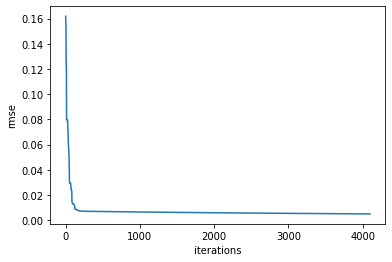

In [76]:
m,n = X_train_std.shape
initial_theta = np.ones((n,1))
w, errors, weights = coordinate_descent_lasso(initial_theta,X_train_std,y_train.values.reshape(-1,1),lamda = .01, num_iters=100, intercept = False)
plt.plot(errors)
plt.xlabel('iterations')
plt.ylabel('rmse')

#### Ridge Mini Batch Gradient Descent

In [77]:
def mini_batch_ridge(X, y, alpha=1e-2,epochs=100,batch_size = 256, l=0):
    n, m = X.shape
    w = np.zeros(X.shape[1])
    weights = []
    errors = []

    for iter in range(epochs):
      np.random.seed(41)
      indices = np.random.permutation(m)
      X_shuffled = X[indices]
      y_shuffled = y.iloc[indices]
            
      for i in range(0,m,batch_size):
        if i+batch_size >= m:
          X_i = X_shuffled[i:]
          y_i = y_shuffled[i:]
        else:
          X_i = X_shuffled[i:i+batch_size]
          y_i = y_shuffled[i:i+batch_size]

        n, m = X_i.shape
        hypothesis = np.dot(X_i, w)
        loss = hypothesis - y_i
        # adds L2 regularizer
        gradient = (np.dot(X_i.T, np.dot(X_i, w)-y_i ) + l*w) * (1.0 / n) 
        w -= alpha * gradient 
        
        errors.append(rmse(np.dot(X, w), y))
        weights.append(w.copy())
      
    return w, errors, weights

training RMSE = 0.00025105361866065005
training RMSE with no regularizaiton = 0.0002510537350651724
testing RMSE = 0.000244646304495623
testing RMSE with no regularizaiton = 0.00024464645914461925


Text(0.5, 1.0, 'testing data')

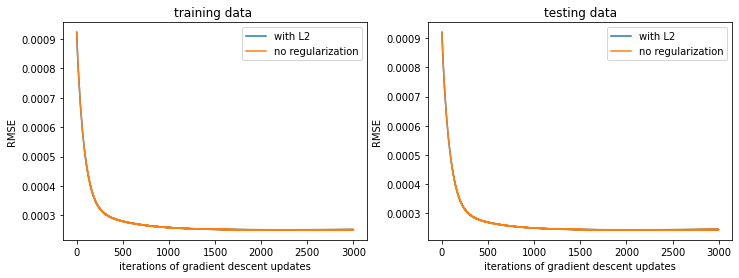

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,  subplot_kw=dict(xlabel="iterations of gradient descent updates", ylabel='RMSE'), figsize=(12,4))

# train with L2
w, errors, weights = mini_batch_ridge(X_train_std,y_train, alpha=1e-2,epochs=1000,batch_size = 16, l=1e-5)
ax1.plot(errors, label='with L2')
print('training RMSE = {}'.format(errors[-1]))

# train with no regularization
w, _, _, errors_noReg, _, weights_noReg = mini_batch_GD(X_train_std,y_train, alpha=1e-2,epochs=1000,batch_size = 16)
ax1.plot(errors_noReg, label='no regularization')
print('training RMSE with no regularizaiton = {}'.format(errors_noReg[-1]))

# test with L2
test_errors = []
for w in weights:
  test_errors.append(rmse(np.dot(X_test_std, w), y_test))
ax2.plot(test_errors, label='with L2')
print('testing RMSE = {}'.format(test_errors[-1]))

# test with no regularization
test_errors_noReg = []
for w in weights_noReg:
  test_errors_noReg.append(rmse(np.dot(X_test_std, w), y_test))
ax2.plot(test_errors_noReg, label='no regularization')
print('testing RMSE with no regularizaiton = {}'.format(test_errors_noReg[-1]))

[ax.legend() for ax in [ax1, ax2]]
ax1.set_title('training data ')
ax2.set_title('testing data')

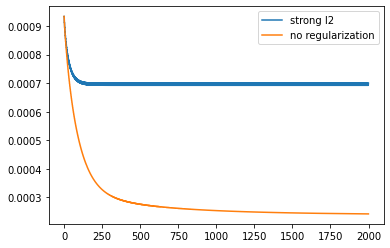

In [79]:
# strong regularization make gradient converge faster
w, errors, weights = mini_batch_ridge(X_train_std,y_train, alpha=1e-2,epochs=1000,batch_size = 32, l=30)
plt.plot(errors, label='strong l2')
w, _, _, errors, _, _ = mini_batch_GD(X_train_std,y_train, alpha=1e-2,epochs=1000,batch_size = 32)
plt.plot(errors, label='no regularization')
plt.legend()

Summarize your findings and explain whether L1 or L2 regularizers are helping the GD convergence. Is it always safe to use a L1 regularizer? How about L2?


* Regularization adds penalty as model complexity increases, so it suppresses the model from overfitting and reduces error. 
* For both L1 and L2, the results showed lower RMSE when regularizations are applied.



|               |no regularization| L1             | L2              |
|---------------|----------------|-----------------|-----------------|
| Training RMSE | 0.000251053735 | 0.0002107639934 | 0.000251053618 |
| Testing RMSE  | 0.000244646459 | 0.0002062197679 | 0.000244646304 |


* In the above plot, it was seen that the model with a very high L2 lambda converged faster because of stronger convex, therefore, yes, regularizer can help GD convergence in some aspect, but it also made the error a lot larger. Regularizer are not aimed to help convergence speed but combat overfitting.





* It's not always safe to use L1 because L1 assigns high weights to most import featuere and shrinks other features' coefficient to zero, removing them altogether. It should not be used when information about each features needs to be preserved. Also, since the weights varies some much, it's not stable to change in datapoints. 
* L2 does not have such effect since it only shrinks coefficients close to zero, but never reaches zero nor removes them. 


## Part 7 - Introducing Momentum

Momentum is a popular technique that helps the gradient descent algorithm to converge faster. Simply, it behaves like a moving average of gradients. 

To summarize, If the weight update formula in the time-step $t$ is $w_t = w_{t-1} - \alpha~g_t$, the $g_t$ using momentum could be computed as $g_t = \beta~g_{t-1} + (1-\beta) \frac{{\partial J}}{\partial w}$. $\beta$ is the momentum coefficient, between [0, 1]. Weight updates ($g_t$) with momentum are not only computed based on the derivative of the loss function but also is a function of previous weight updates.

If you put $\beta=0$ in the $g_t$ equation, it would be the original gradient descent method. 


In [80]:
def gd_momentum(X, y, alpha=1e-2,epochs=100,batch_size = 16, l=1e-5, beta = 0.9):
    n, m = X.shape
    w = np.zeros(X.shape[1])
    costs = np.zeros(epochs)
    errors_perIteration = []
    errors_perEpoch = []
    weights_perEpoch = []
    weights_perIteration = []
    gradient = np.zeros(X.shape[1])

    for iter in range(epochs):
          # create mini batches          
          cost =0.0
          np.random.seed(41)
          indices = np.random.permutation(m)
          X_shuffled = X[indices]
          y_shuffled = y.iloc[indices]

          for i in range(0,m,batch_size):
            if i+batch_size >= m:
              X_i = X_shuffled[i:]
              y_i = y_shuffled[i:]
            else:
              X_i = X_shuffled[i:i+batch_size]
              y_i = y_shuffled[i:i+batch_size]
            n, m = X_i.shape
            # compute gradient descent 
            hypothesis = np.dot(X_i, w)
            loss = hypothesis - y_i
            cost += np.sum(loss ** 2) / (2 * n)
            # add momentum
            gradient = beta*gradient + (1-beta)*((np.dot(X_i.T, loss) + l*w) / n)
            w -= alpha * gradient 
            # computer errors
            error = rmse(np.dot(X, w), y)
            errors_perIteration.append(error)
            weights_perIteration.append(w.copy())

          error = rmse(np.dot(X, w), y)
          errors_perEpoch.append(error)
          weights_perEpoch.append(w.copy())
          costs[iter]  = cost / n
         
    return w, costs, errors_perEpoch, errors_perIteration, weights_perEpoch, weights_perIteration

,train error,test error
beta,,
0.000,0.000293,0.000286
0.800,0.000273,0.000266
0.850,0.000273,0.000265
0.900,0.000271,0.000263
0.950,0.000266,0.000258
0.999,0.000316,0.000315


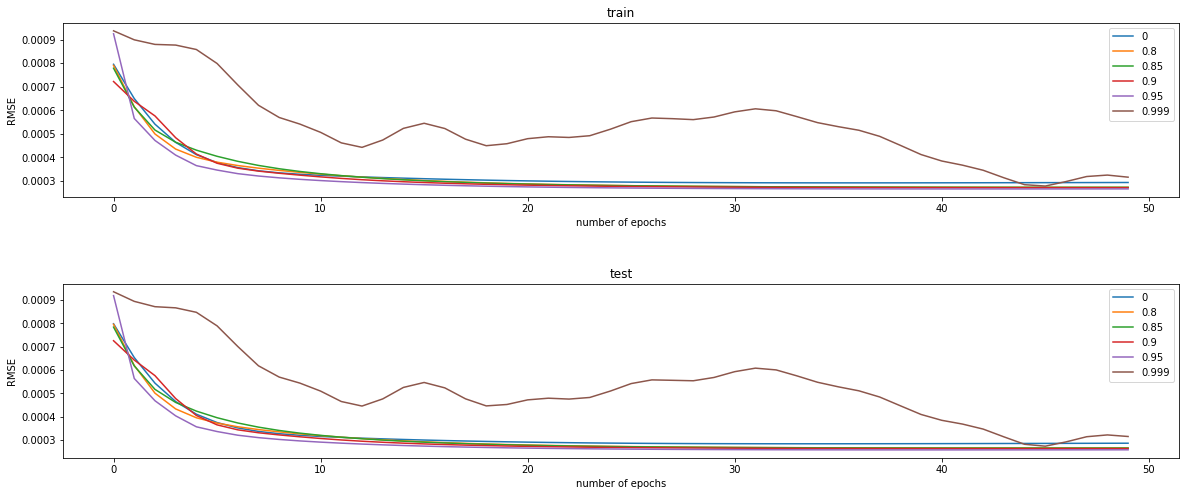

In [81]:
# plot GD with momentum 

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,  subplot_kw=dict(xlabel='number of epochs', ylabel='RMSE'), figsize=(20,8))
plt.subplots_adjust( hspace=0.5 )

trainErr = []
testErr = []

beta = [0, 0.8, 0.85, 0.9, 0.95, 0.999]
for b in beta:
  #train data
  w, costs, errors_epoch, errors_iter, weights_epoch, weights_iter = gd_momentum(X_train_std,y_train, alpha=1e-2,epochs=50,batch_size = 1, l=0, beta=b)
  ax1.plot(errors_epoch, label=b)
  trainErr.append(errors_epoch[-1])

  #validate data 
  test_errors = []
  for w in weights_epoch:
     test_errors.append(rmse(np.dot(X_test_std, w), y_test))
  ax2.plot(test_errors, label=b)
  testErr.append(test_errors[-1])

[ax.legend() for ax in [ax1, ax2]]
ax1.set_title('train')
ax2.set_title('test')

# print table of RMSE for each beta 
import pandas as pd
errors = pd.DataFrame({'train error': trainErr, 'test error': testErr,'beta': beta})
errors.set_index('beta')


# beta = 0.95 help GD converge faster, and also results the smallest error

Text(0.5, 1.0, 'test')

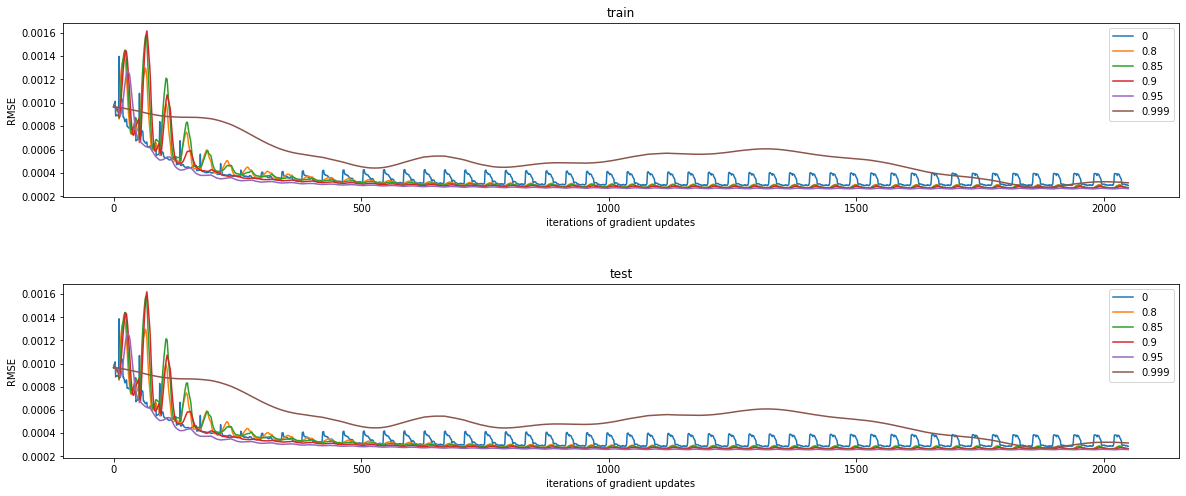

In [82]:
# plots GD with momentum for each iterations

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,  subplot_kw=dict(xlabel='iterations of gradient updates', ylabel='RMSE'), figsize=(20,8))
plt.subplots_adjust( hspace=0.5 )

beta = [0, 0.8, 0.85, 0.9, 0.95, 0.999]
for b in beta:
  w = np.zeros((X_train_std.shape[1],1))
  w, costs, errors_epoch, errors_iter, weights_epoch, weights_iter = gd_momentum(X_train_std,y_train, alpha=1e-2,epochs=50,batch_size = 1, l=0, beta=b)
  ax1.plot(errors_iter, label=b)
  
  test_errors = []
  for w in weights_iter:
     test_errors.append(rmse(np.dot(X_test_std, w), y_test))
  ax2.plot(test_errors, label=b)

[ax.legend() for ax in [ax1, ax2]]
ax1.set_title('train')
ax2.set_title('test')

# plotting each iterations shows how momentum works like a a moving average and removes noises in SGD. 
# The line is smoother when momentum is applied

* The first plot (RMSE vs number of epochs) shows how momentum can help speed up convergence for SGD. 
* Larger momemtum makes the convergence go faster, but not too fast that it overshoots the local (see in beta=0.999)
* After testing various beta, beta=0.95 converges the fastest for this model. It also helps reduce the error.
* The second plot (RMSE vs iterations of gradeint updates) shows how momentum works like a moving average, it smoothes out noise in SGD, so the curve has a lot less fluctuations going up and down. 

## Part 8 - More Application


Apply linear regression model to another dataset. 


* The dataset used is USA house data where the house price will be predicted. 
* It has features: average area income, average area houge age, average area number of rooms, average area number of bedrooms, area population. 
* Since all the features are in continous numbers and formed a numerical relationship with the house price, this dataset is suitable to be modelled using linear regression.

* I trained the model by first computing a linear regresssion with default parameters, it is used as a base model for comparison, then later investigating into adding regularizers and increasing degrees of the regression. Finally select the best model with the parameters that provides the best performance. 


In [40]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
from google.colab import files
uploaded = files.upload()

Saving datasets_4909_7459_USA_Housing.csv to datasets_4909_7459_USA_Housing.csv


In [83]:
df = pd.read_csv('datasets_4909_7459_USA_Housing.csv')

In [84]:
df

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386
...,...,...,...,...,...,...,...
4995,60567.944140,7.830362,6.137356,3.46,22837.361035,1.060194e+06,USNS Williams\nFPO AP 30153-7653
4996,78491.275435,6.999135,6.576763,4.02,25616.115489,1.482618e+06,"PSC 9258, Box 8489\nAPO AA 42991-3352"
4997,63390.686886,7.250591,4.805081,2.13,33266.145490,1.030730e+06,"4215 Tracy Garden Suite 076\nJoshualand, VA 01..."
4998,68001.331235,5.534388,7.130144,5.44,42625.620156,1.198657e+06,USS Wallace\nFPO AE 73316


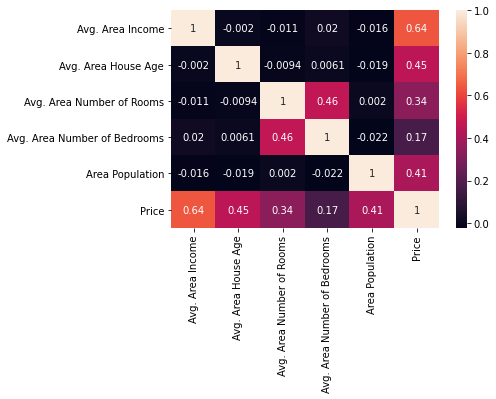

In [85]:
# correlations between features
sns.heatmap(df.corr(), annot=True)

# correlation plots shows all the feautres are independent with low correlations. 

In [86]:
# define features and target
X = df.iloc[:,:5]
y = df['Price']

In [87]:
# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [88]:
# standardize data
# targets ares also standardized to help interpret rmse 
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(pd.concat([X_train, y_train], axis=1)))
test = pd.DataFrame(scaler.transform(pd.concat([X_test, y_test], axis=1)))
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

# add bias to data using constant ones at w0
X_train = np.vstack((np.ones(np.shape(X_train)[0]), X_train.T)).T
X_test =  np.vstack((np.ones(np.shape(X_test)[0]), X_test.T)).T

In [89]:
# direct solution
W = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))

yPred_train = np.dot(X_train, W)
rmse_train = rmse(yPred_train, y_train)
print('training rmse',rmse_train)

yPred_test = np.dot(X_test, W)
rmse_test = rmse(yPred_test, y_test)
print('validation rmse',rmse_test)

training rmse 0.2853276327166379
validation rmse 0.2922422239466734


training rmse: 0.28567971222234745
validation rmse: 0.2924476114136222


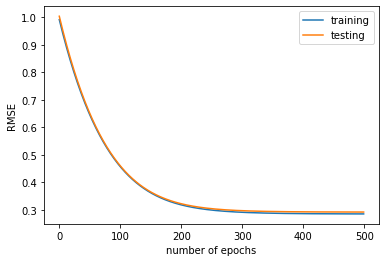

In [90]:
# gradient descent

plt.xlabel('number of epochs')
plt.ylabel('RMSE')

# training data 
w, costs, training_errors, weights = gradientDescent(X_train, y_train, epochs=500)
plt.plot(training_errors)
print('training rmse:', training_errors[-1])

# testing data 
testing_errors = []
for w in weights:
  testing_errors.append(rmse(np.dot(X_test, w), y_test))
plt.plot(testing_errors)
print('validation rmse:', testing_errors[-1])
plt.legend(['training', 'testing'])

Gradient descent results very similar but slightly higher rmse than direct solution.
This model will be used as the base model to evaluate performace of additional tuning

In [91]:
# adding regularizaiton to improve model performance

def ridgeGradientDescent(x, y, alpha=1e-2, epochs=500, l=0):
    n, m = x.shape
    w = np.zeros(x.shape[1])
    errors = []
    weights = []

    for i in range(epochs):
        gradient = (np.dot(x.T, np.dot(x, w)-y ) + l*w) / n 
    
        w -= alpha * gradient 
        weights.append(w.copy())
        # compute rmse error 
        error = rmse(np.dot(x, w), y)
        errors.append(error)
    return weights, errors

def lassoGradientDescent(x, y, alpha=1e-2, epochs=500, l=0):
    n, m = x.shape
    w = np.zeros(x.shape[1])
    errors = []
    weights = []

    for i in range(epochs):
        gradient = (np.dot(x.T, np.dot(x, w)-y ) + l*np.sign(w)) / n 
    
        w -= alpha * gradient 
        weights.append(w.copy())
        # compute rmse error 
        error = rmse(np.dot(x, w), y)
        errors.append(error)
    return weights, errors

In [92]:
# try ridge regression 
training_rmse = []
testing_rmse = []

lambda_ = [0, 0.0001, 0.001, 0.01, 0.1, 1]
for l in lambda_:
  weights, errors = ridgeGradientDescent(X_train,y_train, alpha=1e-2,epochs=500, l=l)
  training_rmse.append(errors[-1])
  testing_rmse.append(rmse(np.dot(X_test, weights[-1]), y_test))
  
pd.DataFrame({'lamda': lambda_, 'training_rmse':training_rmse, 'testing_rmse':testing_rmse})

,lamda,training_rmse,testing_rmse
0,0.0000,0.285680,0.292448
1,0.0001,0.285680,0.292448
2,0.0010,0.285680,0.292448
3,0.0100,0.285680,0.292448
4,0.1000,0.285681,0.292448
5,1.0000,0.285689,0.292451


In [93]:
# try lasso regression 

training_rmse = []
testing_rmse = []

lambda_ = [0, 0.0001, 0.001, 0.01, 0.1, 1]
for l in lambda_:
  weights, errors = lassoGradientDescent(X_train,y_train, alpha=1e-2,epochs=500, l=l)
  training_rmse.append(errors[-1])
  testing_rmse.append(rmse(np.dot(X_test, weights[-1]), y_test))

pd.DataFrame({'lamda': lambda_, 'training_rmse':training_rmse, 'testing_rmse':testing_rmse})


,lamda,training_rmse,testing_rmse
0,0.0000,0.285680,0.292448
1,0.0001,0.285680,0.292448
2,0.0010,0.285680,0.292448
3,0.0100,0.285680,0.292448
4,0.1000,0.285681,0.292447
5,1.0000,0.285693,0.292445


Both ridge and lasso did not reduce RMSE. It means the base model did exploit complexity. So far base model is still the best model. 

Next, try increase polynomial degree to see if the regression will fit better. 

In [94]:
# map orginal features to higher order polynomials
def polynomialMapping(x, degree=2):
  # assume input data has bias at first column
  new_x = pd.DataFrame(x.iloc[:,0], columns=['bias'])
  for i in range(1, x.shape[1]):
    for deg in range(1, degree+1):
      temp = x.iloc[:,i]
      new_x['{}_{}'.format(x.columns[i], deg)] = temp**deg

  return new_x

In [95]:
# original features 
pd.DataFrame(X_train, columns=np.hstack(['bias', X.columns]))

,bias,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population
0,1.0,-0.859631,-1.212894,0.570458,0.273574,-0.499468
1,1.0,0.291359,-1.077496,0.236971,0.835091,0.312396
2,1.0,-1.136886,-0.551706,-0.458693,-0.686702,0.145139
3,1.0,-0.856602,-1.104072,-1.398089,-0.646012,0.809201
4,1.0,-0.455969,2.135344,0.719599,1.933712,-0.484654
...,...,...,...,...,...,...
3495,1.0,-1.119232,0.174719,1.304611,0.265436,-0.824451
3496,1.0,-1.735477,0.662664,0.429290,1.193160,-1.538150
3497,1.0,1.080198,0.465388,-0.484546,-1.207530,-0.966399
3498,1.0,0.408203,-0.765888,-0.113215,0.192195,0.319395


In [96]:
# mapping features to 2nd degree polynomial y=x0+x+x^2
X_train_poly = polynomialMapping(pd.DataFrame(X_train, columns=np.hstack(['bias', X.columns])))
X_test_poly = polynomialMapping(pd.DataFrame(X_test, columns=np.hstack(['bias', X.columns])))
X_train_poly

#number after each feature name represents its polynomial degree

,bias,Avg. Area Income_1,Avg. Area Income_2,Avg. Area House Age_1,Avg. Area House Age_2,Avg. Area Number of Rooms_1,Avg. Area Number of Rooms_2,Avg. Area Number of Bedrooms_1,Avg. Area Number of Bedrooms_2,Area Population_1,Area Population_2
0,1.0,-0.859631,0.738966,-1.212894,1.471112,0.570458,0.325422,0.273574,0.074843,-0.499468,0.249468
1,1.0,0.291359,0.084890,-1.077496,1.160998,0.236971,0.056155,0.835091,0.697377,0.312396,0.097591
2,1.0,-1.136886,1.292510,-0.551706,0.304379,-0.458693,0.210399,-0.686702,0.471560,0.145139,0.021065
3,1.0,-0.856602,0.733768,-1.104072,1.218974,-1.398089,1.954654,-0.646012,0.417332,0.809201,0.654806
4,1.0,-0.455969,0.207907,2.135344,4.559695,0.719599,0.517823,1.933712,3.739242,-0.484654,0.234889
...,...,...,...,...,...,...,...,...,...,...,...
3495,1.0,-1.119232,1.252679,0.174719,0.030527,1.304611,1.702010,0.265436,0.070456,-0.824451,0.679719
3496,1.0,-1.735477,3.011880,0.662664,0.439123,0.429290,0.184289,1.193160,1.423631,-1.538150,2.365906
3497,1.0,1.080198,1.166828,0.465388,0.216586,-0.484546,0.234785,-1.207530,1.458128,-0.966399,0.933927
3498,1.0,0.408203,0.166630,-0.765888,0.586585,-0.113215,0.012818,0.192195,0.036939,0.319395,0.102013


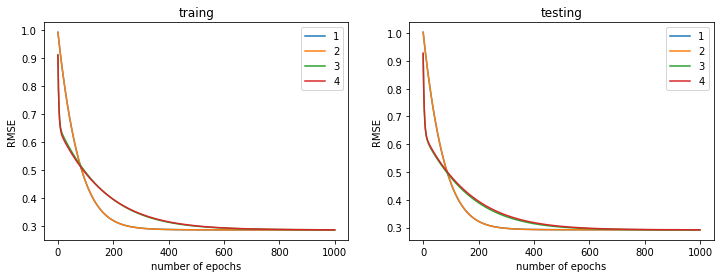

In [97]:
# try polynomial regression with various degrees

training_rmse = []
testing_rmse = []
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4), subplot_kw={'xlabel': 'number of epochs', 'ylabel': 'RMSE'})

degrees = [1,2,3,4]
for i in degrees: 
  # map to polynomial
  X_train_poly = polynomialMapping(pd.DataFrame(X_train, columns=np.hstack(['bias', X.columns])), degree=i)
  X_test_poly = polynomialMapping(pd.DataFrame(X_test, columns=np.hstack(['bias', X.columns])), degree=i)
  # compute gradient descent 
  w, costs, training_errors, weights = gradientDescent(X_train_poly, y_train, epochs=1000)
  ax1.plot(training_errors)
  training_rmse.append(training_errors[-1])
  # calculate rmse  
  testing_errors = []
  for w in weights:
    testing_errors.append(rmse(np.dot(X_test_poly, w), y_test))
  ax2.plot(testing_errors)
  testing_rmse.append(testing_errors[-1])

ax1.set_title('traing')
ax2.set_title('testing')
[ax.legend(degrees) for ax in (ax1, ax2)]

In [98]:
result = pd.DataFrame({'training rmse': training_rmse, 'testing rmse': testing_rmse, 'degree': degrees})
result = result.set_index('degree')
result

,training rmse,testing rmse
degree,,
1,0.285329,0.292243
2,0.285219,0.292072
3,0.285573,0.291611
4,0.285506,0.291996


The result has shown that the 2nd order polynomial fits the data better than 1st degree. 3rd order and above would overfit the model, therefore 2nd order polynomial regression becomes the best model. 

Next, try adding regularizaiton again to the polynomial regression. 

In [99]:
# try ridge regression 
training_rmse = []
testing_rmse = []

X_train_poly = polynomialMapping(pd.DataFrame(X_train, columns=np.hstack(['bias', X.columns])), degree=2)
X_test_poly = polynomialMapping(pd.DataFrame(X_test, columns=np.hstack(['bias', X.columns])), degree=2)

lambda_ = [0, 0.0001, 0.001, 0.01, 0.1, 1]
for l in lambda_:
  weights, errors = lassoGradientDescent(X_train_poly,y_train, alpha=1e-2,epochs=1000, l=l)
  training_rmse.append(errors[-1])
  testing_rmse.append(rmse(np.dot(X_test_poly, weights[-1]), y_test))
  
pd.DataFrame({'lambda': lambda_, 'training_rmse':training_rmse, 'testing_rmse':testing_rmse})

,lambda,training_rmse,testing_rmse
0,0.0000,0.285219,0.292072
1,0.0001,0.285219,0.292072
2,0.0010,0.285219,0.292072
3,0.0100,0.285219,0.292072
4,0.1000,0.285219,0.292072
5,1.0000,0.285221,0.292075


In [100]:
# try ridge regression 
training_rmse = []
testing_rmse = []

X_train_poly = polynomialMapping(pd.DataFrame(X_train, columns=np.hstack(['bias', X.columns])), degree=2)
X_test_poly = polynomialMapping(pd.DataFrame(X_test, columns=np.hstack(['bias', X.columns])), degree=2)

lambda_ = [0, 0.0001, 0.001, 0.01, 0.1, 1]
for l in lambda_:
  weights, errors = ridgeGradientDescent(X_train_poly,y_train, alpha=1e-2,epochs=1000, l=l)
  training_rmse.append(errors[-1])
  testing_rmse.append(rmse(np.dot(X_test_poly, weights[-1]), y_test))
  
pd.DataFrame({'lambda': lambda_, 'training_rmse':training_rmse, 'testing_rmse':testing_rmse})

,lambda,training_rmse,testing_rmse
0,0.0000,0.285219,0.292072
1,0.0001,0.285219,0.292072
2,0.0010,0.285219,0.292072
3,0.0100,0.285219,0.292072
4,0.1000,0.285219,0.292071
5,1.0000,0.285219,0.292066


Regularization did not improve model as the RMSE stayed at the same level, then regularization will not be added to the model because it takes an extra computation step that did not benefit model performace.

---
### Result:

Therefore, out of all the model investigated, the 2nd order polynomial regression is found to be the best model with the smallest RMSE. 
It maps each feature to y=w0+w1x+w2x^2

The model the properties as follows:

In [60]:
X_train_poly = polynomialMapping(pd.DataFrame(X_train, columns=np.hstack(['bias', X.columns])), degree=2)
X_test_poly = polynomialMapping(pd.DataFrame(X_test, columns=np.hstack(['bias', X.columns])), degree=2)

w, costs, training_errors, weights = gradientDescent(X_train_poly, y_train, epochs=1000)
print('training RMSE:', rmse(np.dot(X_train_poly, w), y_train))
print('testing RMSE:', rmse(np.dot(X_test_poly, w), y_test), '\n')
print('weights:', w, '\n')
print('features:', X_train_poly.columns.values)

training RMSE: 0.2852189398353732
testing RMSE: 0.2920717220621275 

weights: [-0.00484083  0.65104257  0.0025291   0.46925123  0.00269978  0.34354009
  0.0035563   0.00839141 -0.00194162  0.42870167 -0.00198287] 

features: ['bias' 'Avg. Area Income_1' 'Avg. Area Income_2' 'Avg. Area House Age_1'
 'Avg. Area House Age_2' 'Avg. Area Number of Rooms_1'
 'Avg. Area Number of Rooms_2' 'Avg. Area Number of Bedrooms_1'
 'Avg. Area Number of Bedrooms_2' 'Area Population_1' 'Area Population_2']
